# **Technical Report**
### **Jiapeng Wang**

## **Introduction & Background**
### **Problem Statement**
Small business owners often face challenges in securing loans due to their limited credit history, making them appear risky to financial institutions. To address this, a credit union offers short-term loans to support small businesses. However, sales fluctuations introduce uncertainty in repayment ability, increasing overall credit risk.

### **Objective**
This analysis aims to assess borrower creditworthiness using the **Performance Ratio at Six Months (PRSM)**, a measure of financial performance that helps predict loan repayment ability. By leveraging financial and business characteristics, we build a predictive model to support lending decisions.

### **Report Structure**
This report presents key steps in the modeling process to ensure clarity and reproducibility. Instead of detailing every step chronologically, it highlights the most critical aspects of data preprocessing, model selection, and assessment. 

The report is organized as follows:
- **Exploratory Data Analysis**: Summary of data characteristics, including key patterns and potential issues.
- **Data Preparation & Feature Engineering**: Handling of missing values, outlier removal, transformations, and new predictor construction.
- **Model Assessment & Insights**: Selection of the final model, evaluation metrics, and diagnostic checks.
- **Key Findings & Future Directions**: Interpretation of results and potential improvements for future analysis.

All analyses are conducted in Jupyter Notebook using Python, with code provided to ensure full reproducibility.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df_train = pd.read_csv('credit_installment2_id5.csv')
df_eval = pd.read_csv('credit_installment2_evaluation_data.csv')

## **Exploratory Data Analysis**
To understand the overall distribution of the features, we visualize the histograms of all variables. This helps in identifying potential skewness, outliers, or other data characteristics that may require transformation.

The figure below presents the distributions of all selected features.


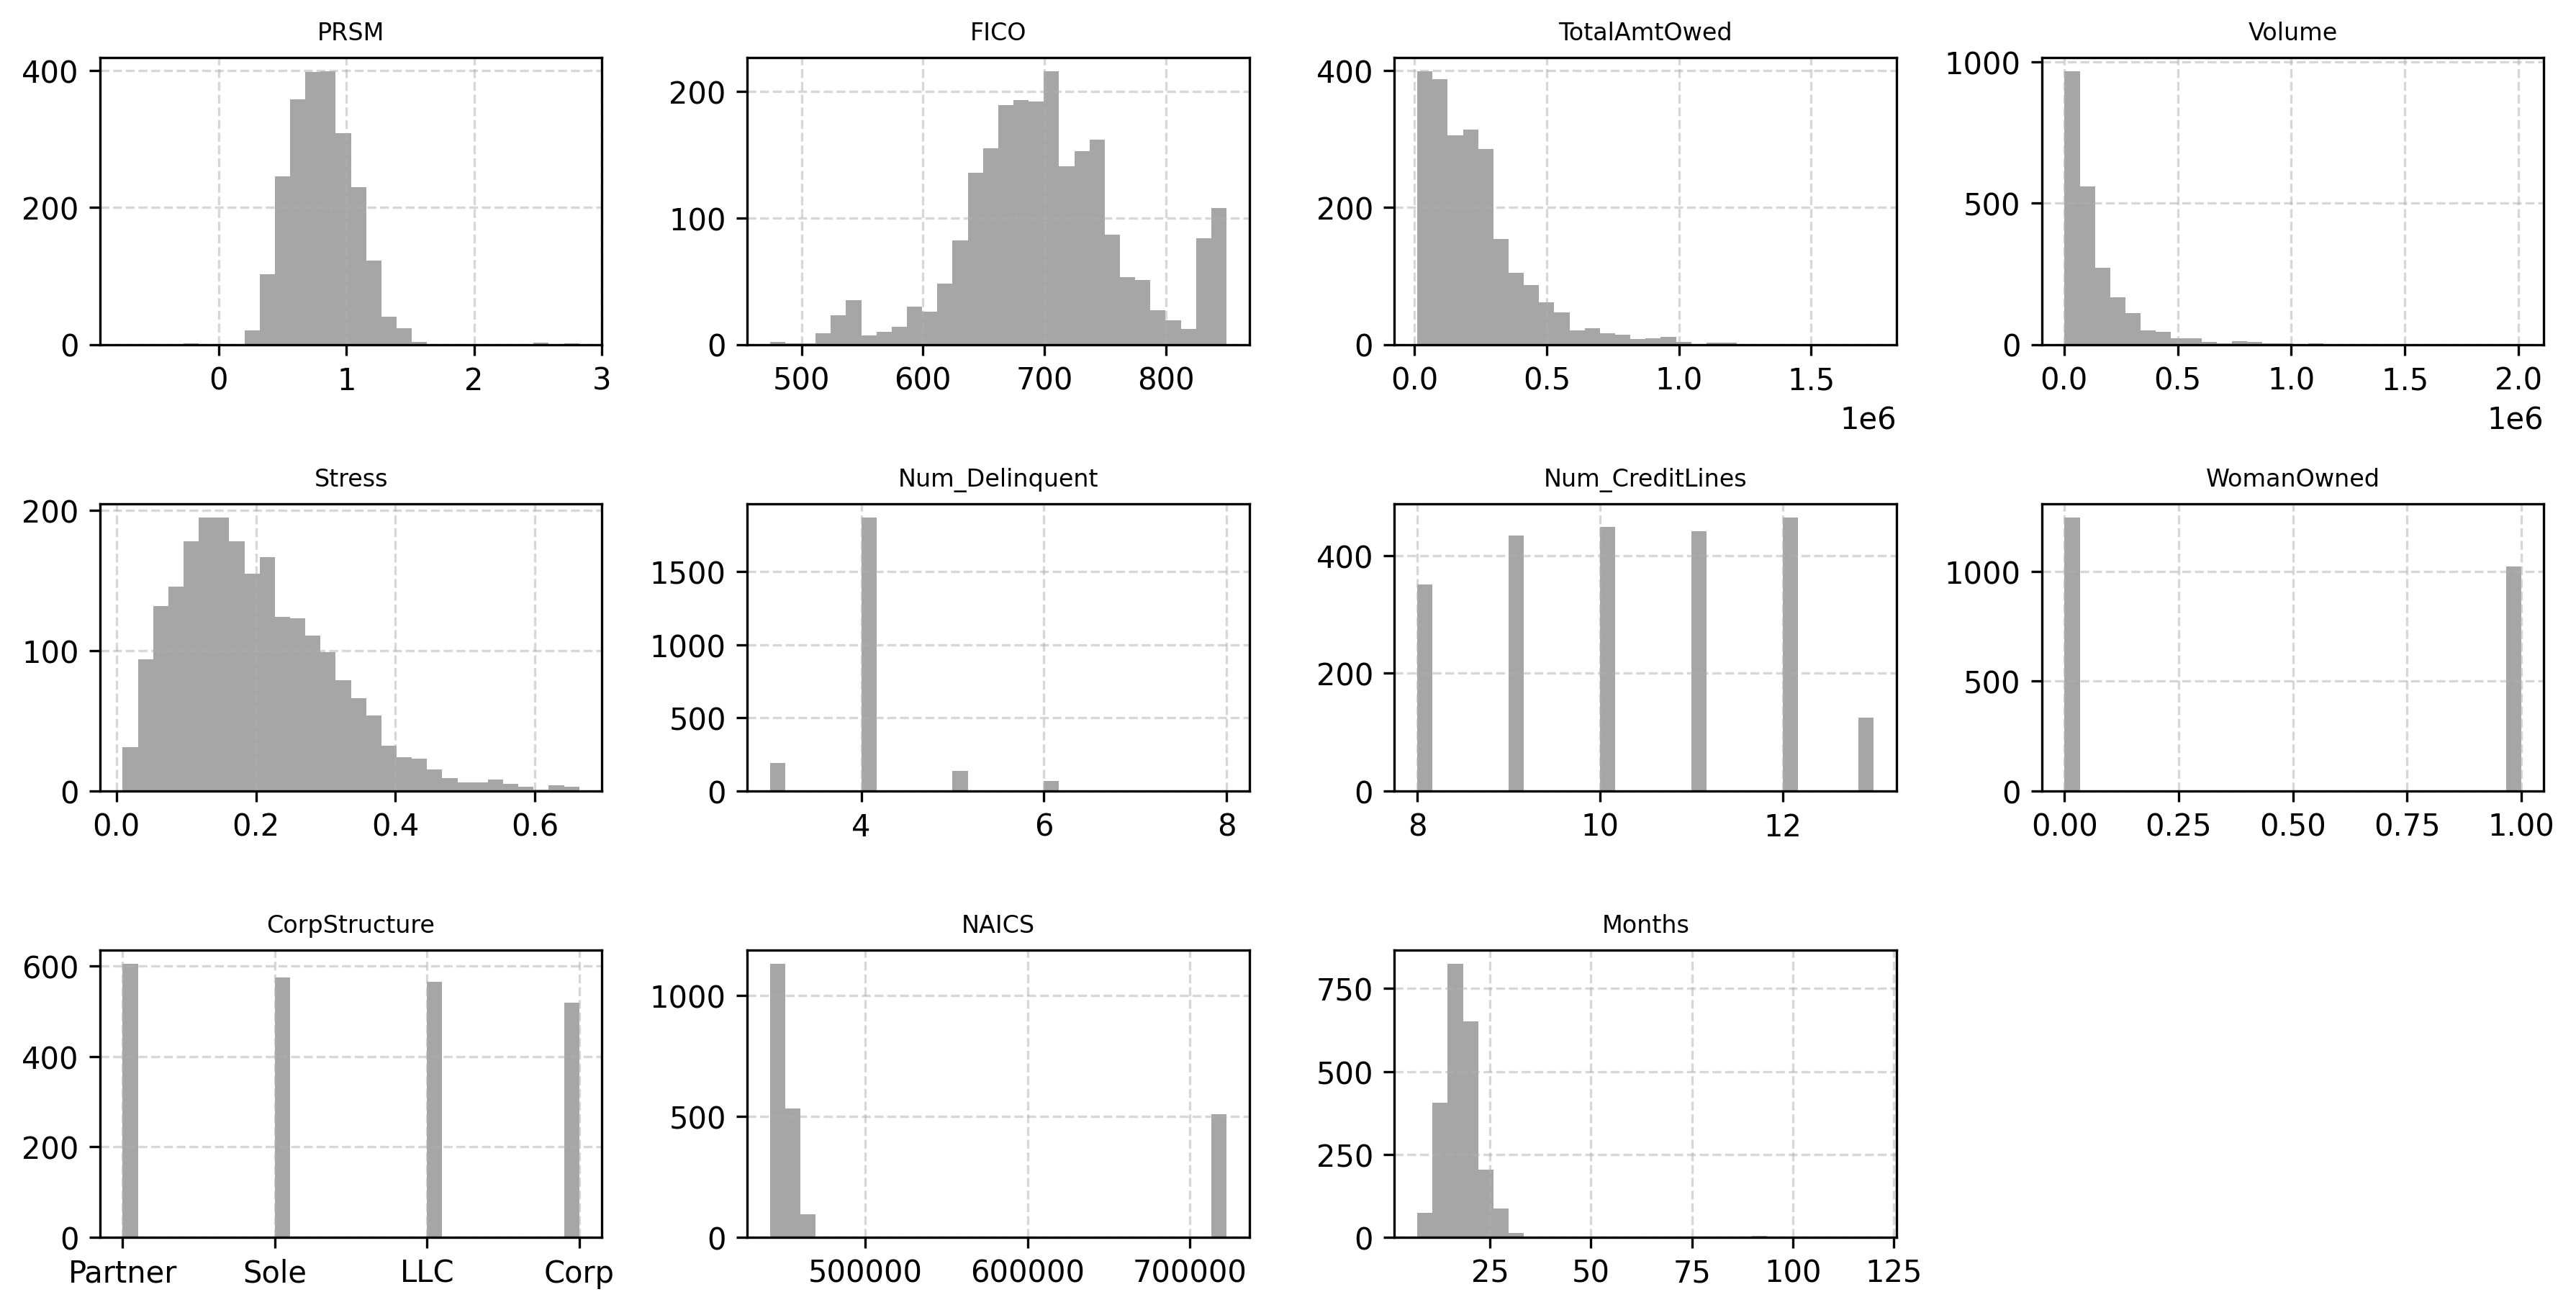

In [2]:
plt.figure(figsize=(12, 8), dpi=300)  

for n, i in enumerate(df_train.iloc[:, 0:].columns):
    plt.subplot(4, 4, n+1)
    plt.title(i, fontsize=8)  
    plt.grid(linestyle='--', alpha=0.5)  
    df_train[i].hist(color='grey', alpha=0.7, bins=30)

plt.tight_layout()
plt.show()

After verifying data completeness using `df_train.info()`, we confirmed that there are no missing values, eliminating the need for imputation.  

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266 entries, 0 to 2265
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PRSM             2266 non-null   float64
 1   FICO             2266 non-null   int64  
 2   TotalAmtOwed     2266 non-null   float64
 3   Volume           2266 non-null   float64
 4   Stress           2266 non-null   float64
 5   Num_Delinquent   2266 non-null   int64  
 6   Num_CreditLines  2266 non-null   int64  
 7   WomanOwned       2266 non-null   int64  
 8   CorpStructure    2266 non-null   object 
 9   NAICS            2266 non-null   int64  
 10  Months           2266 non-null   int64  
dtypes: float64(4), int64(6), object(1)
memory usage: 194.9+ KB


## **Data Preparation & Feature Engineering**
In this section, we describe the preprocessing steps for each feature, including transformations and engineering decisions to improve model performance. These steps ensure that our data is well-structured and suitable for modeling.

We will go through the feature engineering process step by step for each variable.

### **FICO Score Transformation**
The **FICO** score is a critical creditworthiness indicator. Instead of using it as a continuous numerical variable, we categorize it into discrete bins based on industry-standard credit score ranges. This transformation aligns with common credit rating methodologies and may improve model interpretability.

The bins and corresponding labels are defined as follows:  
- **Poor**: 300 – 579  
- **Fair**: 580 – 669  
- **Good**: 670 – 739  
- **Very Good**: 740 – 799  
- **Excellent**: 800+  

In [4]:
bins = [300, 580, 670, 740, 800, float('inf')] 
labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']

df_train['FICO_bin'] = pd.cut(df_train['FICO'], bins=bins, labels=labels, right=False)
df_eval['FICO_bin'] = pd.cut(df_eval['FICO'], bins=bins, labels=labels, right=False)

print(df_train['FICO_bin'].value_counts())

Good         996
Fair         596
Very Good    357
Excellent    223
Poor          94
Name: FICO_bin, dtype: int64


### **Log Transformation for Skewed Continuous Variables**
Some continuous variables exhibit left-skewed distributions, which can negatively impact model performance. To address this, we apply a **log transformation** (`log1p`) to make their distributions more **normal-like**. This helps stabilize variance and improve the effectiveness of regression-based models.

The following variables are transformed:
- **Stress**
- **Volume**
- **TotalAmtOwed**

We use `np.log1p(x)`, which computes `log(1 + x)`, to handle potential zero values without causing undefined results.

In [5]:
df_train['Stress'] = np.log1p(df_train['Stress'])
df_train['Volume'] = np.log1p(df_train['Volume'])
df_train['TotalAmtOwed'] = np.log1p(df_train['TotalAmtOwed'])

df_eval['Stress'] = np.log1p(df_eval['Stress'])  
df_eval['Volume'] = np.log1p(df_eval['Volume'])
df_eval['TotalAmtOwed'] = np.log1p(df_eval['TotalAmtOwed'])

### **Delinquent Credit Ratio**
Instead of using **Num_Delinquent** and **Num_CreditLines** separately, we create a new variable: Delinquent Credit Ratio 

This ratio provides a more **normalized measure of credit risk**, as it captures the proportion of delinquent accounts relative to the total number of credit lines. We hypothesize that this new feature is more predictive of **PRSM** compared to the original two variables.

In [6]:
df_train["Delinquent_Credit_Ratio"] = df_train["Num_Delinquent"] / (df_train["Num_CreditLines"])
df_eval["Delinquent_Credit_Ratio"] = df_eval["Num_Delinquent"] / (df_eval["Num_CreditLines"])

df_train = df_train.drop(['Num_Delinquent', 'Num_CreditLines'], axis=1)
df_eval = df_eval.drop(['Num_Delinquent', 'Num_CreditLines'], axis=1)

### **Feature Engineering: Categorical Variable Transformations**
To improve the model’s ability to handle categorical data, we transform several categorical features into a more structured format and apply one-hot encoding where necessary.

#### **Transforming NAICS Codes**
The **NAICS (North American Industry Classification System) Code** is a six-digit industry classification. Since the first two digits represent the broad industry sector, we extract this as a new categorical variable, `NAICS_2digit`, which provides a more interpretable and generalizable feature.

#### **Encoding Categorical Variables**
We apply **one-hot encoding** to the following categorical features:
- `FICO_bin`: Encoding credit score categories (e.g., Poor, Fair, Good, etc.).
- `CorpStructure`: Encoding the corporate structure of the borrower.
- `NAICS_2digit`: Encoding the industry sector.

In [7]:
df_train['NAICS_2digit'] = df_train['NAICS'].astype(str).str.zfill(6).str[:2] 
df_eval['NAICS_2digit'] = df_eval['NAICS'].astype(str).str.zfill(6).str[:2] 

df_train = pd.get_dummies(df_train, columns=['FICO_bin'], drop_first=True)
df_eval = pd.get_dummies(df_eval, columns=['FICO_bin'], drop_first=True)
df_train = pd.get_dummies(df_train, columns=['CorpStructure'], drop_first=True)
df_eval = pd.get_dummies(df_eval, columns=['CorpStructure'], drop_first=True)
df_train = pd.get_dummies(df_train, columns=['NAICS_2digit'], drop_first=True)
df_eval = pd.get_dummies(df_eval, columns=['NAICS_2digit'], drop_first=True)

df_train = df_train.drop(['FICO', 'NAICS'], axis=1)
df_eval = df_eval.drop(['FICO', 'NAICS'], axis=1)

### **Handling Outliers: Months Variable**
To ensure robust modeling, we examine and adjust outliers in the **Months** variable. Using a **boxplot**, we identify extreme values, and based on the distribution, we **cap** any values exceeding **30** at **30** to prevent excessive skewness.


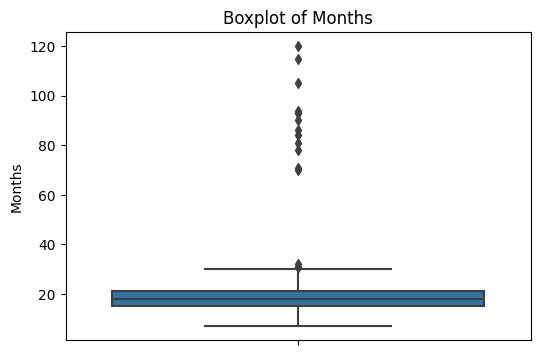

In [8]:
plt.figure(figsize=(6, 4), dpi=100)
sns.boxplot(y=df_train["Months"])
plt.title("Boxplot of Months")
plt.show()

df_train['Months'] = df_train['Months'].apply(lambda x: x if x < 30 else 30)
df_eval['Months'] = df_eval['Months'].apply(lambda x: x if x < 30 else 30)

### **Feature Scaling**
To ensure that all features have a similar scale and to facilitate meaningful coefficient comparisons, we **standardize** numerical variables. This transformation is especially useful when working with **regression models**, as it prevents variables with larger magnitudes from dominating the model. We apply **StandardScaler** to transform the numerical variables. Additionally, we rescale the standardized values using a simple transformation to **shift them into a 0-1 range**, aligning them with **one-hot encoded categorical variables**.

In [9]:
cols_to_scale = ["Months", "Volume", "TotalAmtOwed", "Stress"]

scaler = StandardScaler()

df_train[cols_to_scale] = scaler.fit_transform(df_train[cols_to_scale])
df_eval[cols_to_scale] = scaler.fit_transform(df_eval[cols_to_scale])

df_train[cols_to_scale] = df_train[cols_to_scale] * 0.25 + 0.5
df_eval[cols_to_scale] = df_eval[cols_to_scale] * 0.25 + 0.5

## Model Assessment & Insights: Selection of the final model, evaluation metrics, and diagnostic checks.
### Checking Assumptions of Multiple Linear Regression
Before proceeding with modeling, we need to verify the following key assumptions:

1. **Normality of Residuals**: Residuals should follow a normal distribution.
2. **Homoscedasticity**: The variance of residuals should remain constant.
3. **Multicollinearity**: Independent variables should not have high correlation with each other.
4. **Linearity**: A linear relationship should exist between independent and dependent variables.

We will use the following visualizations to check these assumptions.



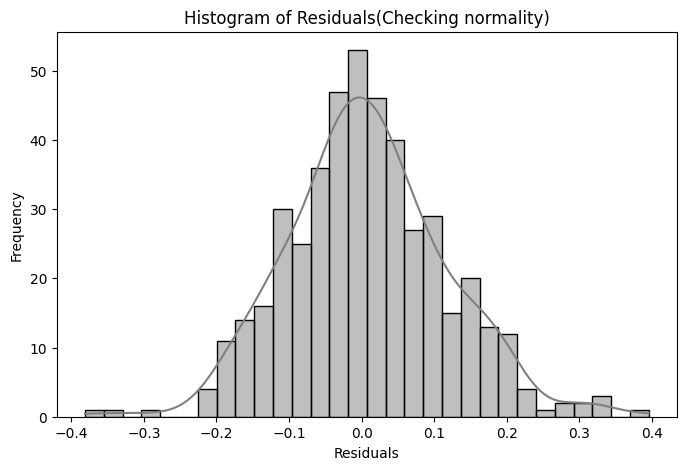

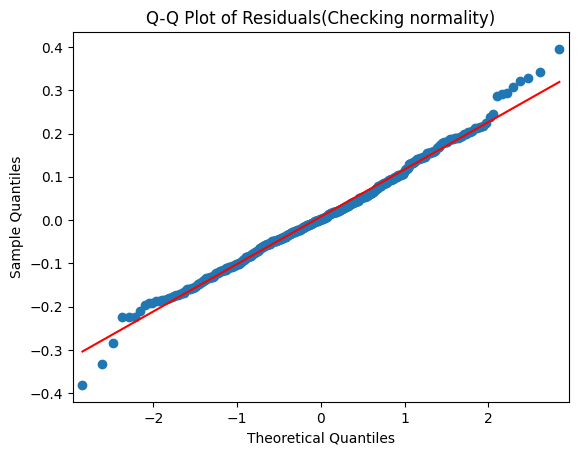

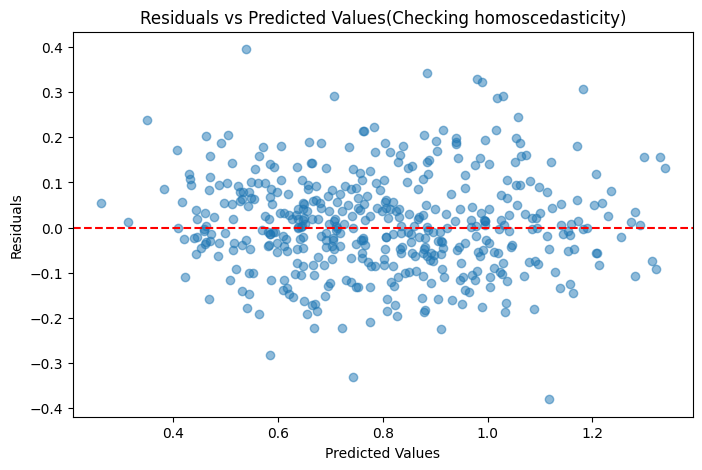

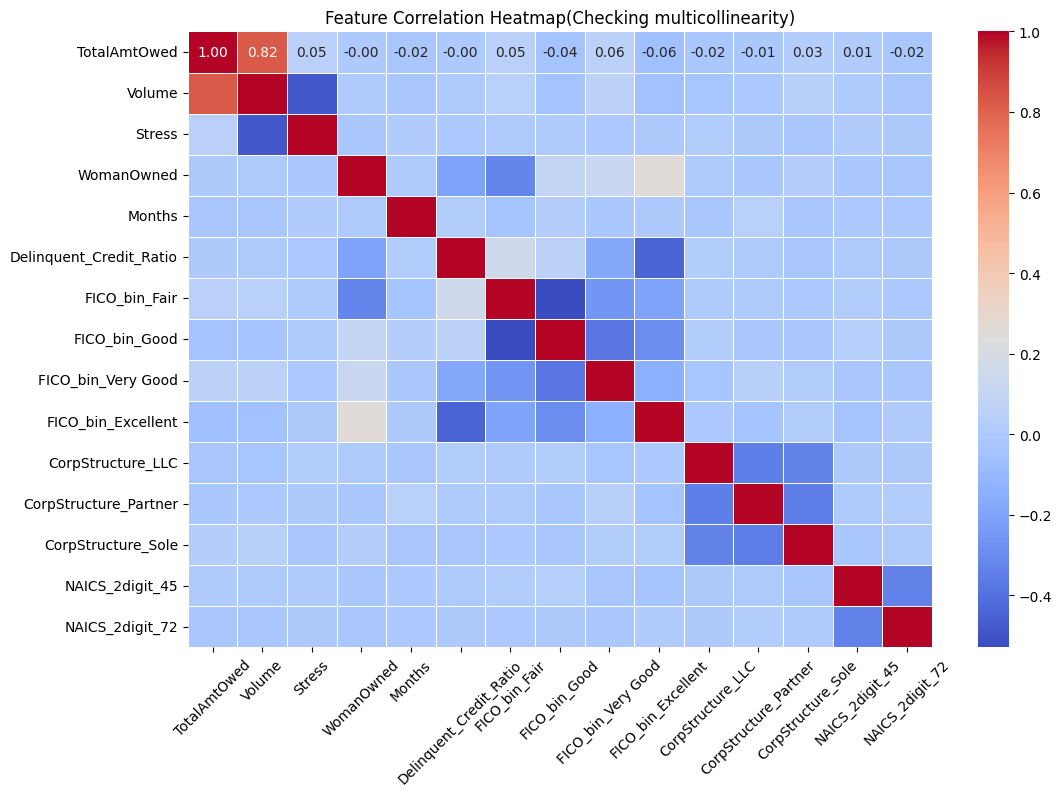

In [10]:
y = df_train['PRSM']
X = df_train.drop(columns=['PRSM'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
residuals = y_test - y_pred

# 1. Distribution of residuals (Checking normality)
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30, color="gray")
plt.title("Histogram of Residuals(Checking normality)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# 2. Q-Q Plot (Checking normality)
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Residuals(Checking normality)")
plt.show()

# 3. Residuals vs. Predicted values (Checking homoscedasticity)
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals vs Predicted Values(Checking homoscedasticity)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# 4. Correlation heatmap (Checking multicollinearity)
correlation_matrix = X.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.xticks(rotation=45)
plt.title('Feature Correlation Heatmap(Checking multicollinearity)')
plt.show()


From the correlation heatmap, we observed that `Volume` is highly correlated with both `TotalAmtOwed` and `Stress`. To further confirm this, we visualize their relationships using scatter plots with regression lines.


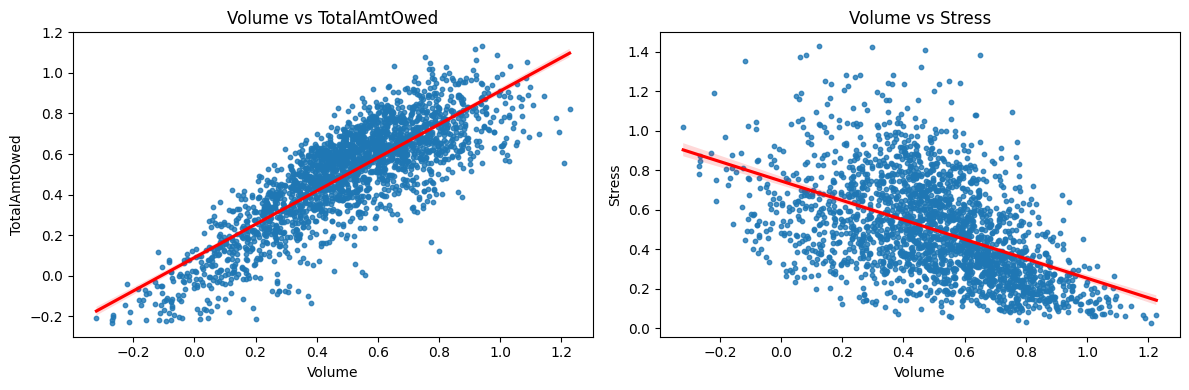

In [11]:
plt.figure(figsize=(12, 4))

# Volume vs TotalAmtOwed
plt.subplot(1, 2, 1)
sns.regplot(x='Volume', y='TotalAmtOwed', data=df_train, scatter_kws={'s': 10}, line_kws={"color": "red"})
plt.title('Volume vs TotalAmtOwed')

# Volume vs Stress
plt.subplot(1, 2, 2)
sns.regplot(x='Volume', y='Stress', data=df_train, scatter_kws={'s': 10}, line_kws={"color": "red"})
plt.title('Volume vs Stress')

plt.tight_layout()
plt.show()


After assessing these relationships, we calculate the **Variance Inflation Factor (VIF)** to quantify multicollinearity. A high VIF value (> 5) suggests that a feature is highly collinear with others, making it a candidate for removal.

In [12]:
def calculate_vif(df, features):
    X = add_constant(df[features])  # Add constant term for VIF calculation
    vif_data = pd.DataFrame({
        "Feature": X.columns,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })
    return vif_data

# Calculate VIF before removing Volume
features_before = ['Months', 'TotalAmtOwed', 'Stress', 'Volume']
print("VIF before removing Volume:")
print(calculate_vif(df_train, features_before))

# Drop Volume
df_train.drop(columns=['Volume'], inplace=True)
df_eval.drop(columns=['Volume'], inplace=True)

# Calculate VIF after removing Volume
features_after = ['Months', 'TotalAmtOwed', 'Stress']
print("\nVIF after removing Volume:")
print(calculate_vif(df_train, features_after))

VIF before removing Volume:
        Feature        VIF
0         const  67.076286
1        Months   1.000502
2  TotalAmtOwed  21.885714
3        Stress   9.371525
4        Volume  28.801306

VIF after removing Volume:
        Feature        VIF
0         const  12.613981
1        Months   1.000502
2  TotalAmtOwed   1.003336
3        Stress   1.003224


Based on these analyses, we decide to **drop `Volume`** from our dataset to avoid redundancy and multicollinearity.

### Final Model Training and Evaluation
We fit an **Ordinary Least Squares (OLS) regression model** using the **Statsmodels** library. OLS regression helps us understand the relationship between the independent variables and the target variable by estimating regression coefficients.

To ensure robustness, we evaluate the model using **5-fold cross-validation**:
1. Add a **constant term** to the feature set to account for the intercept.
2. Train an **OLS regression model** on the training data.
3. Compute the **Root Mean Squared Error (RMSE)** for each fold.
4. Report the **average RMSE** and its **standard deviation** to assess model stability.

This approach ensures that our model generalizes well across different data splits.

In [13]:
y = df_train['PRSM']
X = df_train.drop(columns=['PRSM'])

kf = KFold(n_splits=5, shuffle=True, random_state=19)

rmse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Add constant term for OLS regression
    X_train_sm = sm.add_constant(X_train)
    X_test_sm = sm.add_constant(X_test)
    
    # Fit OLS model
    ols_model = sm.OLS(y_train, X_train_sm).fit()
    
    # Predict on the test set
    y_pred = ols_model.predict(X_test_sm)
    
    # Compute RMSE for the current fold
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    rmse_scores.append(rmse)

# Print results
print(f'Average RMSE: {np.mean(rmse_scores):.4f}')
print(f'RMSE Standard Deviation: {np.std(rmse_scores):.4f}')

Average RMSE: 0.1558
RMSE Standard Deviation: 0.0374


### Model Summary and Feature Importance
After fitting the **OLS regression model**, we can inspect the detailed summary of the model, which includes coefficients, p-values, R-squared values, and other statistical metrics that help assess the quality and significance of the model.


In [14]:
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   PRSM   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     330.4
Date:                Fri, 21 Feb 2025   Prob (F-statistic):               0.00
Time:                        11:59:04   Log-Likelihood:                 1039.2
No. Observations:                1813   AIC:                            -2048.
Df Residuals:                    1798   BIC:                            -1966.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

## Predictions Generation
To generate predictions for the evaluation dataset using the trained model, we use the following steps:

1. **Train the Model on All Data:** First, we train the model using the entire dataset (X and y), ensuring that it leverages all available information for making predictions.
2. **Generate Predictions:** Using the trained model, we make predictions on the evaluation data and calculate the point predictions along with the corresponding prediction intervals.
3. **Save the Results:** The predictions, along with their confidence intervals, are saved to a CSV file for further use or reporting.

In [15]:
X_train_sm = sm.add_constant(X)
ols_model = sm.OLS(y, X_train_sm).fit()

df_eval = sm.add_constant(df_eval)
predictions = ols_model.get_prediction(df_eval)

pred_summary = predictions.summary_frame(alpha=0.05)

output_df = pred_summary[['mean', 'obs_ci_lower', 'obs_ci_upper']]
output_df.columns = ['fit', 'lwr', 'upr']

output_df.index += 1
output_df.to_csv("predictions.csv")

## Key Findings & Future Directions

The following is an interpretation of the terms included in the final model based on the regression coefficients and their statistical significance. These terms provide insights into the key drivers of credit risk, as indicated by the model's output.

### Key Drivers of Credit Risk

1. **Intercept (Const)**  
   - **Coefficient**: 0.1334  
   - **Interpretation**: The intercept term represents the baseline PRSM score when all the other variables are set to zero. This value is positive, indicating a baseline level of creditworthiness for a company with all features at their minimum values.

2. **Loan Amount (TotalAmtOwed)**  
   - **Coefficient**: 0.3239  
   - **Interpretation**: Larger loans are associated with higher PRSM scores, suggesting that businesses with higher debt amounts tend to have stronger cash flow or better repayment performance. This positive relationship indicates that higher loan amounts are not necessarily linked to higher credit risk in this model.

3. **Financial Stress (Stress)**  
   - **Coefficient**: 0.2138  
   - **Interpretation**: Higher financial stress, represented by the Stress variable, is positively related to PRSM scores. This suggests that businesses with higher levels of financial stress may be deemed higher-risk, likely due to poor financial management or operational difficulties.

4. **Women-Owned Businesses (WomanOwned)**  
   - **Coefficient**: 0.2784  
   - **Interpretation**: The positive coefficient indicates that women-owned businesses tend to have higher PRSM scores, potentially due to factors like better financial management, different risk profiles, or a focus on industries that perform well in credit assessments.

5. **Months in Business (Months)**  
   - **Coefficient**: 0.1076  
   - **Interpretation**: A longer time in business is associated with higher PRSM scores. This relationship suggests that businesses that have been operating for a longer period tend to be less risky and have a proven track record, reducing their credit risk.

6. **Delinquent Credit Ratio (Delinquent_Credit_Ratio)**  
   - **Coefficient**: 0.0699  
   - **Interpretation**: The Delinquent_Credit_Ratio shows a positive relationship with PRSM scores, but this relationship is not statistically significant (p-value = 0.175). The lack of significance suggests that this ratio does not strongly influence creditworthiness in this dataset.

7. **FICO Score Categories (FICO_bin_Fair, FICO_bin_Good, FICO_bin_Very Good, FICO_bin_Excellent)**  
   - **Interpretation**:  
     - **Fair (FICO_bin_Fair)**: A fair FICO score is associated with a slight increase in PRSM scores compared to the baseline (p-value = 0.021).  
     - **Good (FICO_bin_Good)**: A good FICO score significantly improves the PRSM score (coefficient = 0.1176, p-value < 0.001), indicating a positive influence on creditworthiness.  
     - **Very Good (FICO_bin_Very Good)**: Businesses with a very good FICO score show a similar positive relationship with PRSM scores (coefficient = 0.1364, p-value < 0.001).  
     - **Excellent (FICO_bin_Excellent)**: An excellent FICO score strongly correlates with higher PRSM scores (coefficient = 0.2488, p-value < 0.001), highlighting the importance of FICO scores in determining creditworthiness.

8. **Business Structure (CorpStructure_LLC, CorpStructure_Partner, CorpStructure_Sole)**  
   - **Interpretation**:  
     - **LLC**: LLCs are associated with higher PRSM scores (coefficient = 0.2271), suggesting that businesses structured as LLCs tend to have better credit risk profiles.  
     - **Partner**: Partnerships also have higher PRSM scores (coefficient = 0.1510), though less so than LLCs.  
     - **Sole Proprietorship**: Sole proprietorships have a slight negative relationship with PRSM scores (coefficient = -0.0159), indicating that they may carry higher credit risk compared to LLCs and partnerships, though the relationship is marginally insignificant (p-value = 0.084).

9. **Industry Code (NAICS_2digit)**  
   - **Interpretation**:  
     - **NAICS_2digit_45 (Retail)**: This industry code shows a negative relationship with PRSM scores, suggesting that businesses in this sector may have higher credit risks.  
     - **NAICS_2digit_72 (Accommodation and Food Services)**: This category has a very small and statistically insignificant effect on PRSM scores (p-value = 0.722), indicating that it does not strongly influence creditworthiness.

### Summary
- **Key Positive Drivers**: Larger loan amounts, women-owned businesses, longer operational histories, and higher FICO scores (Good, Very Good, Excellent) significantly increase PRSM scores.
- **Less Significant or Insignificant Drivers**: Delinquent Credit Ratio and certain business structures (e.g., sole proprietorship) are less impactful in explaining credit risk in this model.
- **Industry Effects**: The retail sector (NAICS 45) is associated with lower creditworthiness, while the accommodation and food services sector (NAICS 72) shows no significant effect.

These interpretations help to identify which factors are most crucial in determining the creditworthiness of businesses in this dataset.


### Explanation of Baseline Borrower Selection

The baseline borrower was chosen based on approximate median or average values from the training data. The goal was to represent a typical borrower in the dataset for the purpose of estimating the predicted PRSM score. These values were selected to provide a balanced and realistic representation of the typical characteristics of borrowers, reflecting both the central tendency and common characteristics within the dataset.

#### **Baseline Borrower Characteristics:**
- **FICO Score**: 700  
  - This value is representative of a borrower with a decent credit score, falling within the "Fair" range. It is a typical score seen in the dataset, providing a good balance for understanding credit risk.
  
- **Loan Amount**: 200,000  
  - The loan amount was selected based on its proximity to the average loan amount in the data, providing a reasonable loan size that many businesses in the sample have.

- **Volume**: 140,000  
  - This value represents a typical annual business volume, indicative of a medium-sized business within the dataset.

- **Stress**: 0.2  
  - Financial stress, represented by a low value, is intended to reflect a relatively stable financial situation for a typical borrower.

- **Number of Delinquent Accounts**: 4  
  - This is the approximate median value in the dataset, representing a borrower with a few past delinquencies.

- **Number of Credit Lines**: 10  
  - An average number of credit lines for a typical borrower, which reflects standard access to credit.

- **Woman-Owned**: Yes  
  - The value is set to 1 (indicating woman-owned), as this feature was included in the dataset as a significant factor influencing PRSM scores.

- **Business Structure**: LLC  
  - LLCs are commonly found among businesses in the dataset, and this value was chosen as a representative of the most frequent business structure.

- **NAICS Code**: 445291  
  - This NAICS code corresponds to a typical business in the dataset, representing an industry in line with the majority of sample businesses.

- **Months in Business**: 18  
  - An average value reflecting the age of a typical business in the dataset, indicating a moderate duration of operation.

#### **Baseline PRSM Prediction:**
- **Predicted PRSM**: 0.92 (95% Prediction Interval: 0.60 – 1.24)

This baseline borrower serves as a standard reference point for understanding how changes in various characteristics (such as FICO score, loan amount, or business structure) impact creditworthiness as measured by PRSM scores. By adjusting individual features, we can observe how these changes affect the predicted PRSM score, helping to evaluate the potential risks associated with different borrower profiles.

#### **Impact of Key Changes:**
- **FICO 850 → PRSM: 1.00 (0.68 – 1.32)** ; **FICO 450 → PRSM: 0.88 (0.56 – 1.19)**
- **Loan Amount 500K → PRSM: 0.96 (0.64 – 1.28)** ; **Loan Amount 50K → PRSM: 0.86 (0.54 – 1.18)**
- **Stress 0.05 → PRSM: 0.80 (0.48 – 1.12)** ; **Stress 0.50 → PRSM: 1.12 (0.80 – 1.44)**
- **Non-Woman-Owned → PRSM: 0.71 (0.39 – 1.02)**
- **Business Structure: Corporation → PRSM: 0.69 (0.37 – 1.00)** ; **Business Structure: Sole Proprietorship → PRSM: 0.83 (0.52 – 1.15)** ; **Business Structure: Partnership → PRSM: 0.92 (0.60 – 1.23)**
- **Months in Business 30 → PRSM: 1.11 (0.79 – 1.43)** ; **Months in Business 3 → PRSM: 0.68 (0.36 – 1.00)**

By evaluating the baseline borrower and how changes to their characteristics impact the PRSM score, we can gain a deeper understanding of the key drivers of credit risk for different business types and conditions.

### Future Work

#### **Improving Data Analysis**
- **Explore Feature Interactions:** Investigate how different features interact with each other to uncover potential hidden patterns that could provide deeper insights into credit risk and borrower behavior.
- **Test Advanced Models:** Evaluate the use of more advanced machine learning models, such as Random Forests or Gradient Boosting, to improve accuracy and interpretability. These models may capture complex relationships that linear models cannot.
- **Enhance Weak Features:** Work on improving the predictive power of features like **NAICS** by incorporating additional external data sources or feature engineering techniques to provide richer insights.

#### **Next Steps for Business Impact**
- **Validate the Model with Real-World Testing:** Apply the model to real-world datasets to verify its accuracy and robustness in predicting credit risk, ensuring that it performs well under various business conditions.
- **Integrate into Decision-Making Processes:** Embed the model into existing credit risk assessment processes to assist decision-making, allowing businesses to use the PRSM score to make more informed decisions on borrower approvals and credit limits.
- **Monitor Performance and Refine:** Continuously monitor the model's performance as new data becomes available. Refine and retrain the model periodically to adapt to changing market conditions, ensuring its relevance and effectiveness over time.
